## Analysis Testing Type II: Leave-One-Year-Out (LOYO)


In [1]:
import operator
import os
import datetime
import gc
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
import scipy

import xgboost as xgb

import shap
import cv2
import imgaug

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def filterNoData2(band):
    band_filtered = band

    operatorLookup = {">": operator.gt, "<": operator.lt}

    threshold = 100
    comparison = ">"

    # check if noData value is extremely large or small
    if len(band_filtered[band_filtered > 100]) > 0:
        threshold = 100
        comparison = ">"

    elif len(band_filtered[band_filtered < -100]) > 0:
        threshold = -100
        comparison = "<"

    op = operatorLookup.get(comparison)

    # find the indices of the non-noData pixels
    nonNoDataIndices = np.where(~op(band, threshold))

    # determine the minimum and maximum row and column indices of the non-noData pixels
    rowIndices = (min(nonNoDataIndices[0]), max(nonNoDataIndices[0]))
    colIndices = (min(nonNoDataIndices[1]), max(nonNoDataIndices[1]))

    # extract a subarray that only includes the non-noData pixels
    croppedImg = band[
        rowIndices[0] : rowIndices[1] + 1, colIndices[0] : colIndices[1] + 1
    ]

    band_filtered = croppedImg

    # iterate through rows
    offset = 0
    for row in range(0, band_filtered.shape[0]):
        # delete row if more than 1/3 of it contains noData values
        if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 3:
            # if len(np.argwhere(op(band_filtered[row - offset], threshold))) > 0.15 * len(band_filtered[row - offset]):
            # print(f"Deleting row {row} with offset {offset}")
            band_filtered = np.delete(band_filtered, row - offset, 0)
            offset += 1

        row += 1

    # iterate through cols
    offset = 0
    for col in range(0, band_filtered.shape[1]):
        if len(np.argwhere(op(band_filtered[:, col - offset], threshold))) > 0:
            # print(f"Deleting column {col} with offset {offset}")
            band_filtered = np.delete(band_filtered, col - offset, 1)
            offset += 1

        col += 1

    return band_filtered

#### Load Yield Data


In [3]:
df_2021 = pd.read_csv("../../Datasets/Agronomic/2021/Dataset_2021.csv")
df_2022 = pd.read_csv("../../Datasets/Agronomic/2022/Dataset_2022.csv")

df_2021 = df_2021.sort_values(by="Plot_Number")
df_2022 = df_2022.sort_values(by="Plot_Number")

# remove missing yield
df_2021 = df_2021[df_2021["Yield"].notna()].reset_index(drop=True)
df_2022 = df_2022[df_2022["Yield"].notna()].reset_index(drop=True)

# get plot Numbers
df_2021["Plot_Number"] = df_2021["Plot_Number"].astype(str)
df_2022["Plot_Number"] = df_2022["Plot_Number"].astype(str)

plotNumbers_2021 = list(df_2021["Plot_Number"].unique())
plotNumbers_2022 = list(df_2022["Plot_Number"].unique())

# keep only necessary attributes
df_2021 = df_2021.iloc[:, [0, 1, 2, 5, 6, 7]]
df_2022 = df_2022.iloc[:, [0, 1, 2, 5, 6, 7]]
df_2021

,Plot_Number,Rice_Cultivar,Experiment_Name,Nitrogen_Rate,Replicate,Yield
0,33761,IAC600,Tiara,75,1,6.002350
1,33762,Tiara,Tiara,75,1,5.922051
2,33763,Sierra,Tiara,75,1,8.331022
3,33764,Scarlett,Tiara,75,1,10.565055
4,33765,Tiara,Tiara,75,1,6.693495
...,...,...,...,...,...,...
219,35848,WAB462-10-3-1,Mini_Core,130,4,8.652218
220,35852,Jefferson,Mini_Core,130,4,10.722785
221,35853,EMBRAPA 1200,Mini_Core,130,4,10.430267
222,35856,XP753,Mini_Core,130,4,21.821254


#### Load Models


In [4]:
# load modeling approach 3 models
h2a3m1 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_3/Saved_Models/H2A3M1"
)
h2a3m2 = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_3/Saved_Models/H2A3M2"
)
testEmbedding = joblib.load(
    "../Proposed_Models/Proposed_Modeling_Approach_3/Saved_Models/Transformed_Data/2022"
)

# load modeling approach 4 model
h2a4m1 = tf.keras.models.load_model(
    "../Proposed_Models/Proposed_Modeling_Approach_4/Saved_Models/H2A4M1.keras"
)

#### Preprocess Images (for 3D-CNN)


In [5]:
imgsPath = "../../Datasets/Images"
LATE_BOOT_DATES_2021 = ["06-14-2021", "06-23-2021", "06-30-2021", "07-28-2021"]

LATE_BOOT_DATES_2022 = ["06-09-2022", "06-17-2022", "06-25-2022", "07-19-2022"]

RESIZE_DIM = (40, 18)


# 0: train, 1: test

imgs = [[], []]

dates = [[], []]

imgIndex = 0


for imgSet in os.listdir(imgsPath):

    for date in sorted(os.listdir(os.path.join(imgsPath, imgSet))):

        # filter dates

        if (date in LATE_BOOT_DATES_2021) or (date in LATE_BOOT_DATES_2022):

            imgIndex = 0 if imgSet == "Train" else 1

            dates[imgIndex].append(date)


            print(f"Working on {date} for {imgSet} set")


            for plotNumber in sorted(os.listdir(os.path.join(imgsPath, imgSet, date))):

                # filter missing yield plots

                if (plotNumber in plotNumbers_2021) or (plotNumber in plotNumbers_2022):

                    imgDir = os.path.join(imgsPath, imgSet, date, plotNumber)


                    # read imgs -> filter noData pixels -> resize to predefined dimension

                    r = cv2.resize(

                        filterNoData2(cv2.imread(os.path.join(imgDir, "red.tiff"), -1)),

                        RESIZE_DIM,

                        cv2.INTER_AREA,
                    )

                    g = cv2.resize(

                        filterNoData2(

                            cv2.imread(os.path.join(imgDir, "green.tiff"), -1)
                        ),

                        RESIZE_DIM,

                        cv2.INTER_AREA,
                    )

                    b = cv2.resize(

                        filterNoData2(

                            cv2.imread(os.path.join(imgDir, "blue.tiff"), -1)
                        ),

                        RESIZE_DIM,

                        cv2.INTER_AREA,
                    )

                    nir = cv2.resize(

                        filterNoData2(cv2.imread(os.path.join(imgDir, "nir.tiff"), -1)),

                        RESIZE_DIM,

                        cv2.INTER_AREA,
                    )

                    r_e = cv2.resize(

                        filterNoData2(

                            cv2.imread(os.path.join(imgDir, "red_edge.tiff"), -1)
                        ),

                        RESIZE_DIM,

                        cv2.INTER_AREA,
                    )


                    # Stack the 5 channels

                    imgs[imgIndex].append(np.stack((r, g, b, nir, r_e), axis=2))


xTrain = np.stack(imgs[0], axis=0)

xTest = np.stack(imgs[1], axis=0)


del (
    r,
    g,

    b,
    nir,
    r_e,

    imgSet,
    date,

    plotNumber,

    imgDir,

    imgsPath,
    imgs,

    imgIndex,
)

Working on 06-09-2022 for Test set
Working on 06-17-2022 for Test set
Working on 06-25-2022 for Test set
Working on 07-19-2022 for Test set
Working on 06-14-2021 for Train set
Working on 06-23-2021 for Train set
Working on 06-30-2021 for Train set
Working on 07-28-2021 for Train set


In [6]:
# Reorder images such that the same plot across timepoints is consecutive (to be able to reshape later)
xTrainTimepoints = np.empty(shape=xTrain.shape)

counter = 0
for plot in np.arange(0, len(df_2021), 1):
    for timepoint in np.arange(plot, len(xTrain), len(df_2021)):
        xTrainTimepoints[counter] = xTrain[timepoint, :, :, :]
        counter += 1

# add time dimension
N_TIMEPOINTS = 4
xTrainTimepoints = xTrainTimepoints.reshape(
    (len(df_2021), N_TIMEPOINTS) + xTrainTimepoints.shape[1:]
)

del counter, plot, timepoint

xTestTimepoints = np.empty(shape=xTest.shape)

counter = 0
for plot in np.arange(0, len(df_2022), 1):
    for timepoint in np.arange(plot, len(xTest), len(df_2022)):
        xTestTimepoints[counter] = xTest[timepoint, :, :, :]
        counter += 1

# add time dimension
xTestTimepoints = xTestTimepoints.reshape(
    (len(df_2022), N_TIMEPOINTS) + xTestTimepoints.shape[1:]
)

del counter, plot, timepoint

In [7]:
scaler = StandardScaler()
xTrainScaled = scaler.fit_transform(
    xTrainTimepoints.reshape(-1, xTrainTimepoints.shape[-1])
).reshape(xTrainTimepoints.shape)

xTestScaled = scaler.transform(
    xTestTimepoints.reshape(-1, xTestTimepoints.shape[-1])
).reshape(xTestTimepoints.shape)

In [8]:
dateDf = pd.concat([df_2022] * len(dates[1])).reset_index(drop=True)
dateDf["Date"] = np.nan

start = 0
end = 1
for date in dates[1]:
    dateDf.iloc[len(df_2022) * start : len(df_2022) * end, -1] = date
    start += 1
    end += 1

dfEmbeddingTest = pd.concat(
    [dateDf.reset_index(drop=True), pd.DataFrame(testEmbedding)], axis=1
)

# rename components
for i in range(len(dateDf.columns), len(dfEmbeddingTest.columns), 1):
    dfEmbeddingTest.rename(
        columns={
            dfEmbeddingTest.columns[i]: "UMAP_" + str(i - len(dateDf.columns) + 1)
        },
        inplace=True,
    )

del start, end, date, dateDf, i

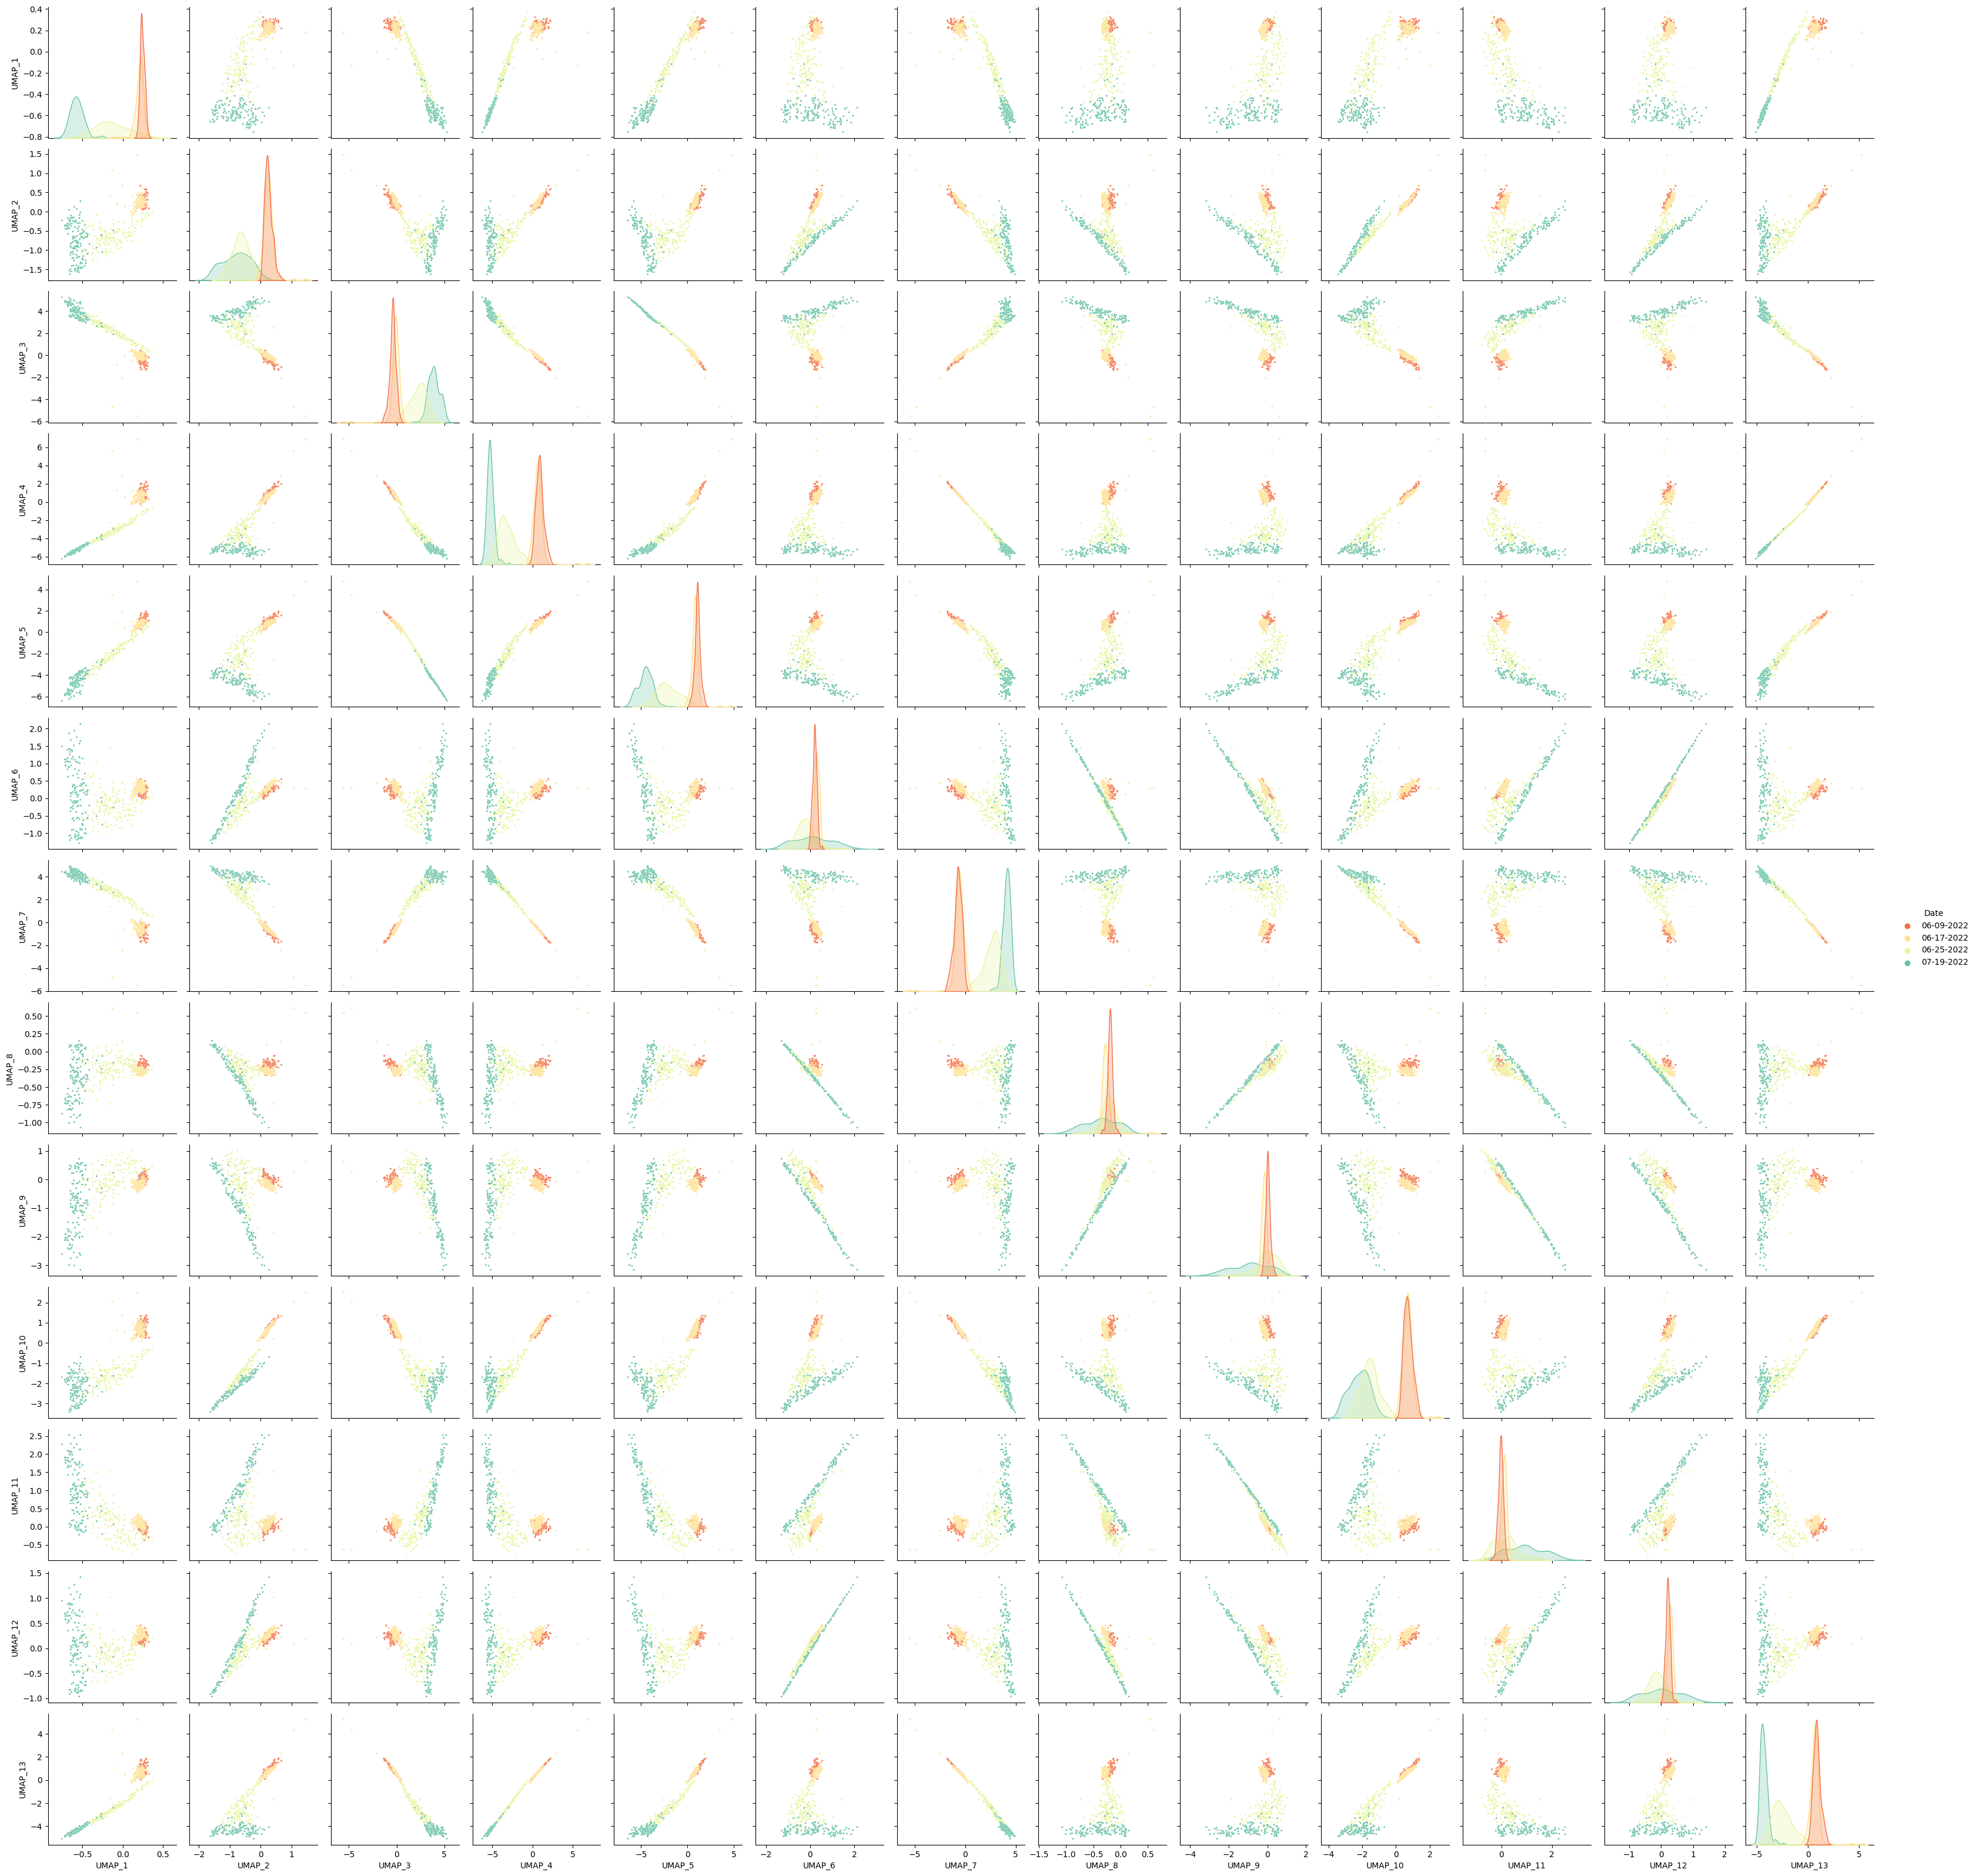

In [14]:
sns.pairplot(
    dfEmbeddingTest.loc[
        :,
        ["Date"]
        + list(
            dfEmbeddingTest.columns[
                dfEmbeddingTest.columns.get_loc(
                    "UMAP_1"
                ) : dfEmbeddingTest.columns.get_loc("UMAP_13")
                + 1
            ]
        ),
    ],
    hue="Date",
    palette="Spectral",
    plot_kws={"s": 5},
)

In [9]:
# wide to long then long to wide
dfLongTest = pd.melt(
    dfEmbeddingTest,
    id_vars=dfEmbeddingTest.iloc[:, :7],
    value_vars=dfEmbeddingTest.iloc[:, 7:],
)

dfWideTest = pd.pivot(
    dfLongTest,
    columns=["Date", "variable"],
    values="value",
    index=[
        "Plot_Number",
        "Rice_Cultivar",
        "Experiment_Name",
        "Nitrogen_Rate",
        "Replicate",
        "Yield",
    ],
).reset_index()

dfWideTest.columns = [
    str(s1) + "_" + str(s2) if str(s2) != "" else str(s1)
    for (s1, s2) in dfWideTest.columns.tolist()
]

del dfLongTest

In [10]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    "Generates data for Keras"

    def __init__(
        self,
        X,
        y,
        batch_size=28,
        dim=(N_TIMEPOINTS, 18, 40),
        n_channels=5,
        shuffle=False,
        augment=False,
    ):
        "Initialization"
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(self.X.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, X_temp):
        "Generates data containing batch_size samples"
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, index in enumerate(X_temp):
            # Store sample
            X[i,] = self.X[index]

            # Store yield label
            y[i] = self.y[index]

        if self.augment:
            X = self.augment_images(X)

        return X, y

    def augment_images(self, imgs):
        "Randomly applies augmentation to images"
        for i in range(len(imgs)):
            lefRightProb = tf.random.uniform([]).numpy() > 0.5
            upDownProb = tf.random.uniform([]).numpy() > 0.5
            rotateProb = tf.random.uniform([]).numpy() > 0.5
            scaleProb = tf.random.uniform([]).numpy() > 0.5

            rotateAngle = tf.random.uniform([], minval=-25, maxval=25).numpy()
            scaleFactor = tf.random.uniform([], minval=0.6, maxval=1.4).numpy()

            # apply same augmentation to each timepoint of a single plot
            for timepoint in range(imgs[i].shape[0]):
                imgs[i, timepoint] = tf.cond(
                    lefRightProb,
                    lambda: imgaug.augmenters.flip.fliplr(imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

                imgs[i, timepoint] = tf.cond(
                    upDownProb,
                    lambda: imgaug.augmenters.flip.flipud(imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

                imgs[i, timepoint] = tf.cond(
                    rotateProb,
                    lambda: imgaug.augmenters.geometric.Affine(
                        rotate=rotateAngle,
                        mode="reflect",
                    )(image=imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

                imgs[i, timepoint] = tf.cond(
                    scaleProb,
                    lambda: imgaug.augmenters.geometric.Affine(
                        scale=scaleFactor,
                        mode="reflect",
                    )(image=imgs[i, timepoint]),
                    lambda: imgs[i, timepoint],
                )

        return imgs

#### Compute Predictions


In [11]:
results = dfWideTest.iloc[:, :6]
xTest = dfWideTest.iloc[:, 6:].values
yTest = dfWideTest["Yield"]

# model always predicting the mean
predictions = [df_2021["Yield"].mean()] * len(yTest)
results["Constant_Model"] = predictions

print(
    f"CONSTANT MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# lasso pumap
predictions = h2a3m1.predict(xTest)
results["Lasso_PUMAP"] = predictions

print(
    f"LASSO_PUMAP MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# xgboost pumap
dtest = xgb.DMatrix(xTest, label=yTest)
predictions = h2a3m2.predict(dtest)
results["XGBoost_PUMAP"] = predictions

print(
    f"XGBOOST_PUMAP MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

# 3D-CNN
testGenerator = CustomDataGenerator(
    xTestScaled, yTest, shuffle=False, augment=False, batch_size=1
)
predictions = h2a4m1.predict(testGenerator)[:, 0]
results["3D-CNN"] = predictions

print(
    f"3D-CNN MODEL: "
    f"\nRMSE: {round(mean_squared_error(yTest, predictions, squared=False), 4)}"
    f"\nMAE: {round(mean_absolute_error(yTest, predictions), 4)}"
    f"\nMBE: {round(np.mean(predictions - yTest), 4)}"
    f"\nMAPE: {round(mean_absolute_percentage_error(yTest, predictions), 4)}"
    f"\nR^2: {round(r2_score(yTest, predictions), 4)}"
    f"\n-----------------------------------------------------"
)

CONSTANT MODEL: 
RMSE: 4.1644
MAE: 3.604
MBE: 1.3029
MAPE: 0.6308
R^2: -0.1085
-----------------------------------------------------
LASSO_PUMAP MODEL: 
RMSE: 4.2222
MAE: 3.6383
MBE: -0.5894
MAPE: 0.5259
R^2: -0.1395
-----------------------------------------------------
XGBOOST_PUMAP MODEL: 
RMSE: 4.2829
MAE: 3.6717
MBE: -0.5576
MAPE: 0.5113
R^2: -0.1725
-----------------------------------------------------
152/152 [==============================] - 6s 5ms/step
3D-CNN MODEL: 
RMSE: 3.3514
MAE: 2.7168
MBE: -1.203
MAPE: 0.3458
R^2: 0.2821
-----------------------------------------------------


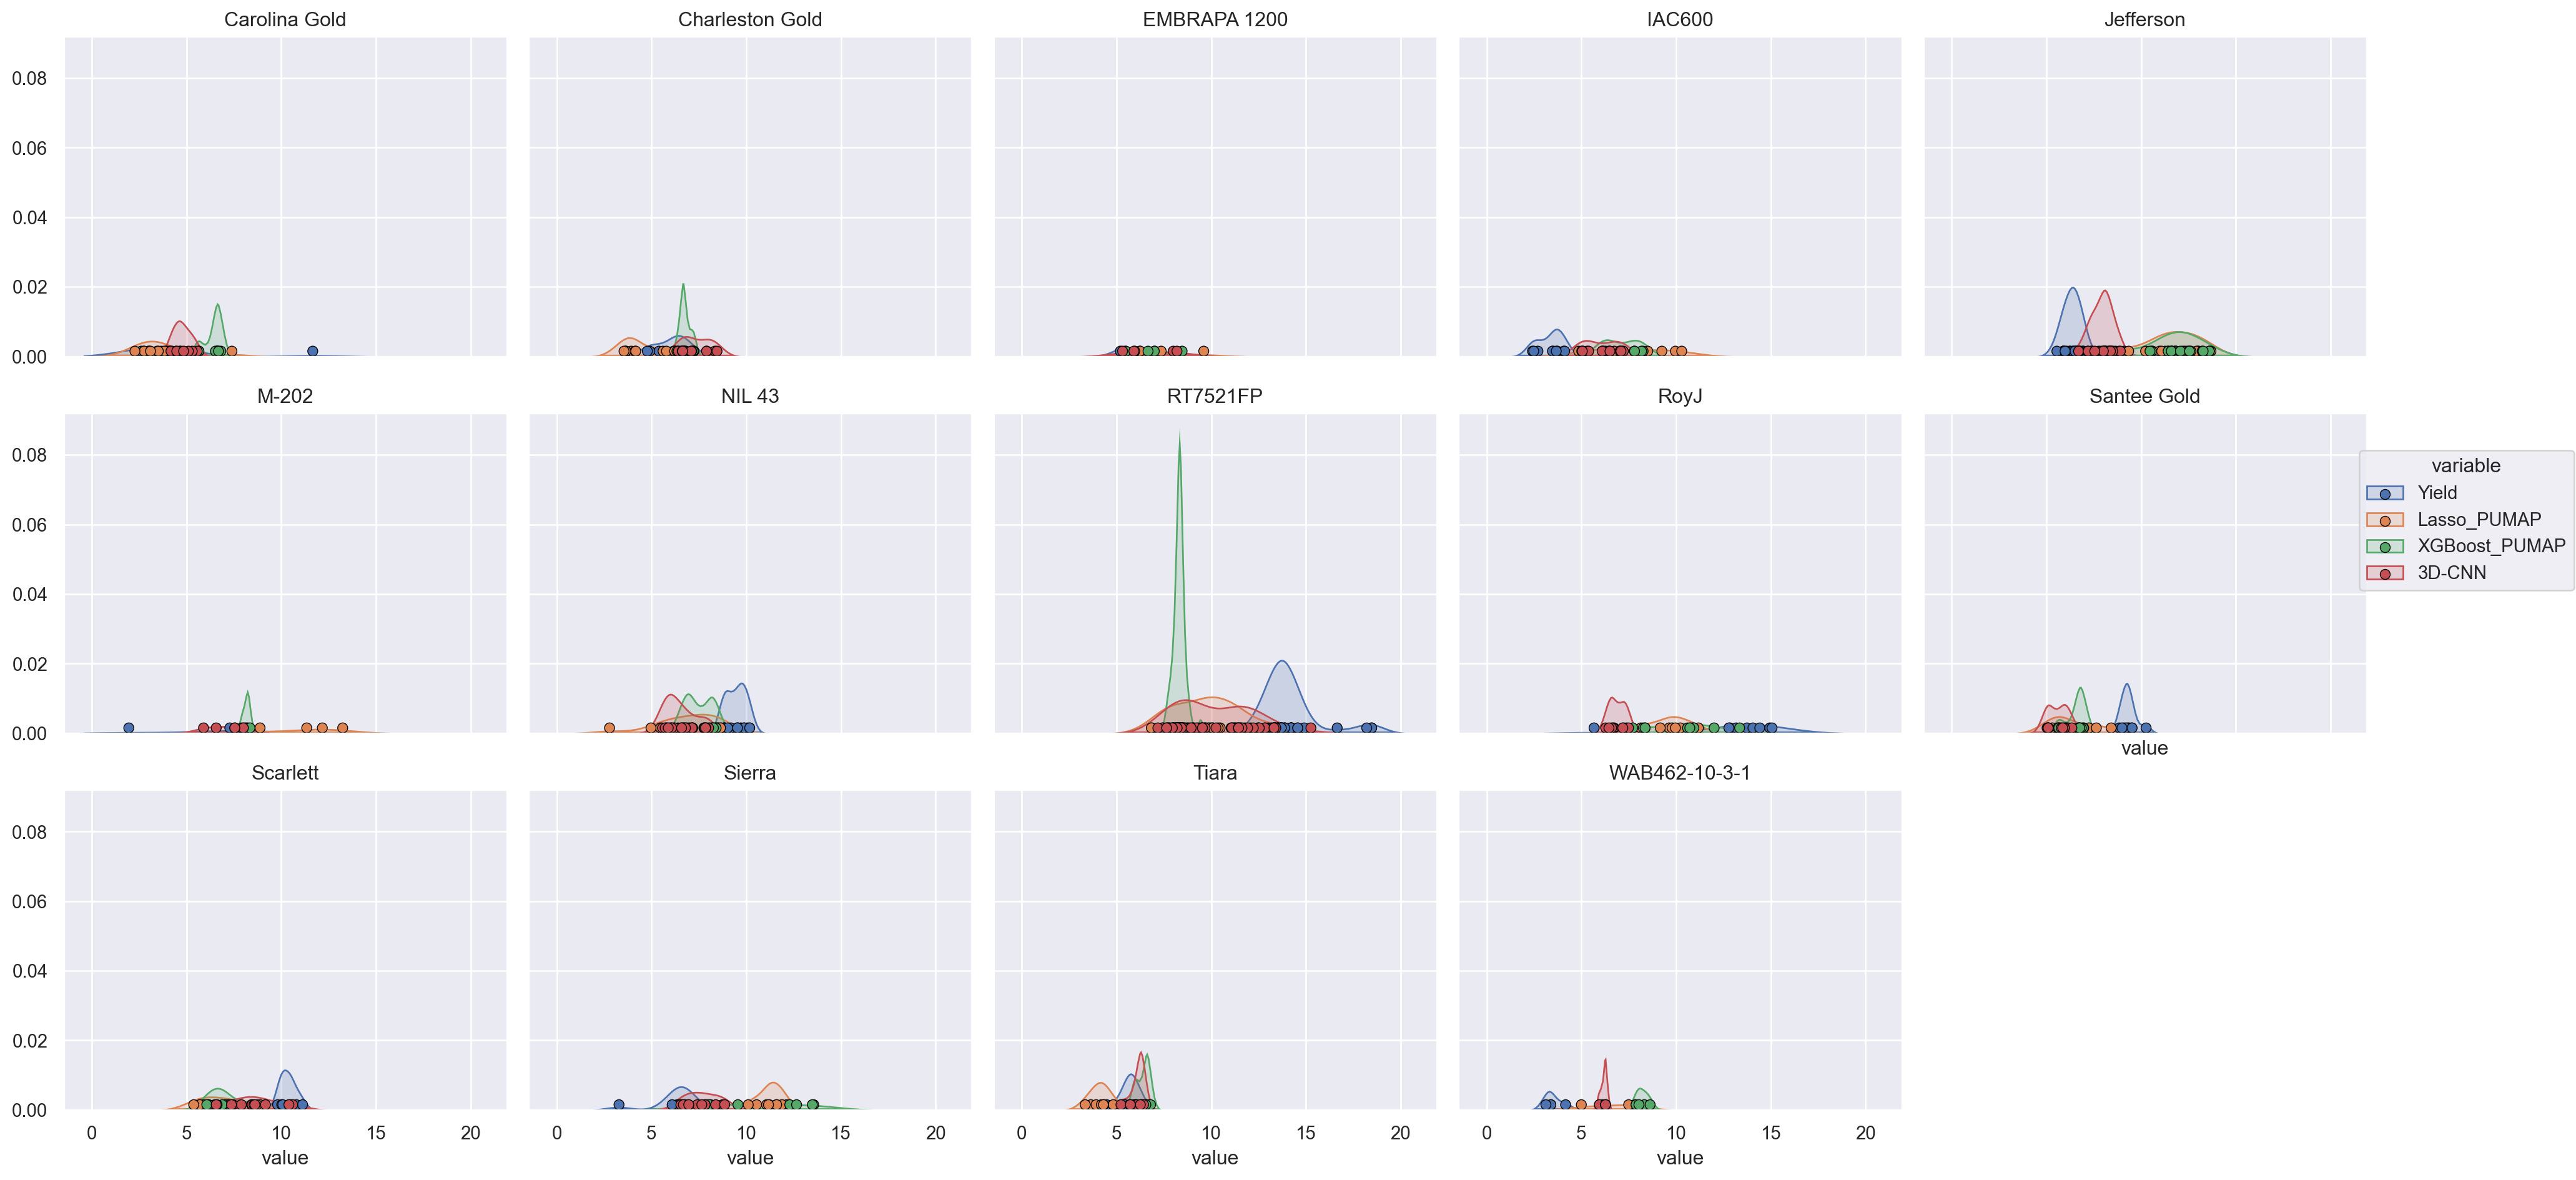

In [13]:
# testDf = df_2022.copy().reset_index(drop=True)
# testDf["Yield_pred"] = preds

temp = pd.melt(
    results,
    id_vars=results.columns[:-5],
    value_vars=["Yield", "Lasso_PUMAP", "XGBoost_PUMAP", "3D-CNN"],
)
(
    so.Plot(
        temp,
        x="value",
    )
    .layout(size=(20, 10))
    .facet(
        col="Rice_Cultivar",
        order=sorted(temp["Rice_Cultivar"].unique()),
        wrap=5,
    )
    .add(so.Area(), so.KDE(), color="variable")
    .add(so.Dot(edgecolor="black"), y=[0.0015] * len(temp), color="variable")
)

# del temp

In [37]:
explainer = shap.Explainer(lambda x: h2a3m1.predict(x), xTest)
shapValues = explainer.shap_values(xTest)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


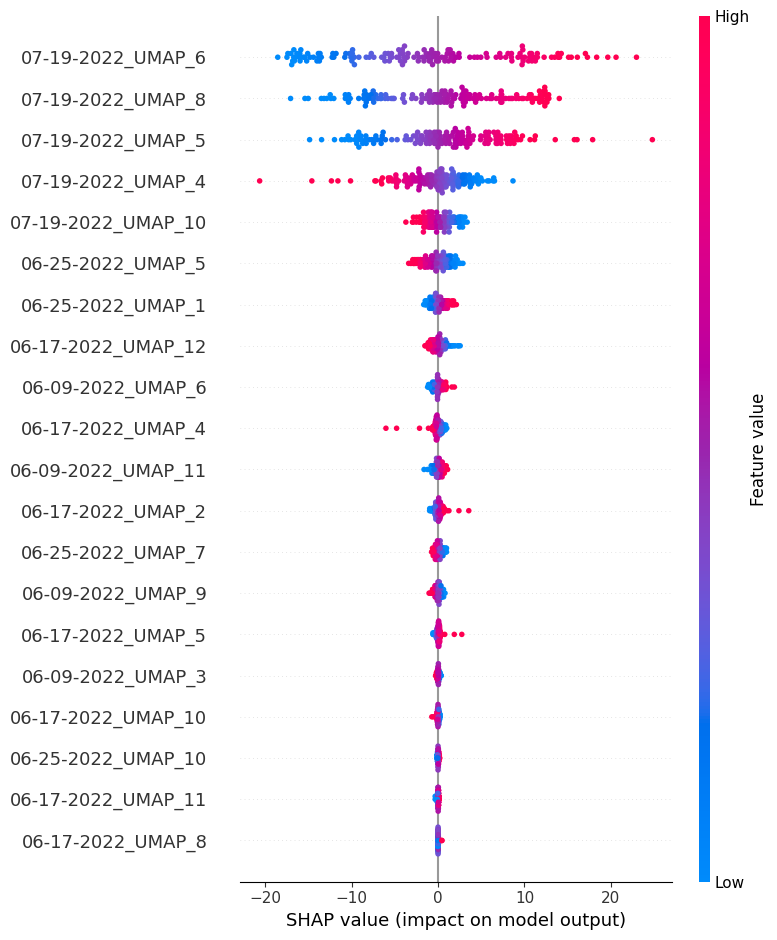

In [38]:
shap.summary_plot(
    shapValues, plot_type="dot", feature_names=dfWideTest.columns[6:], features=xTest
)

In [39]:
explainer = shap.Explainer(h2a3m2)
shapValues = explainer(xTest)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


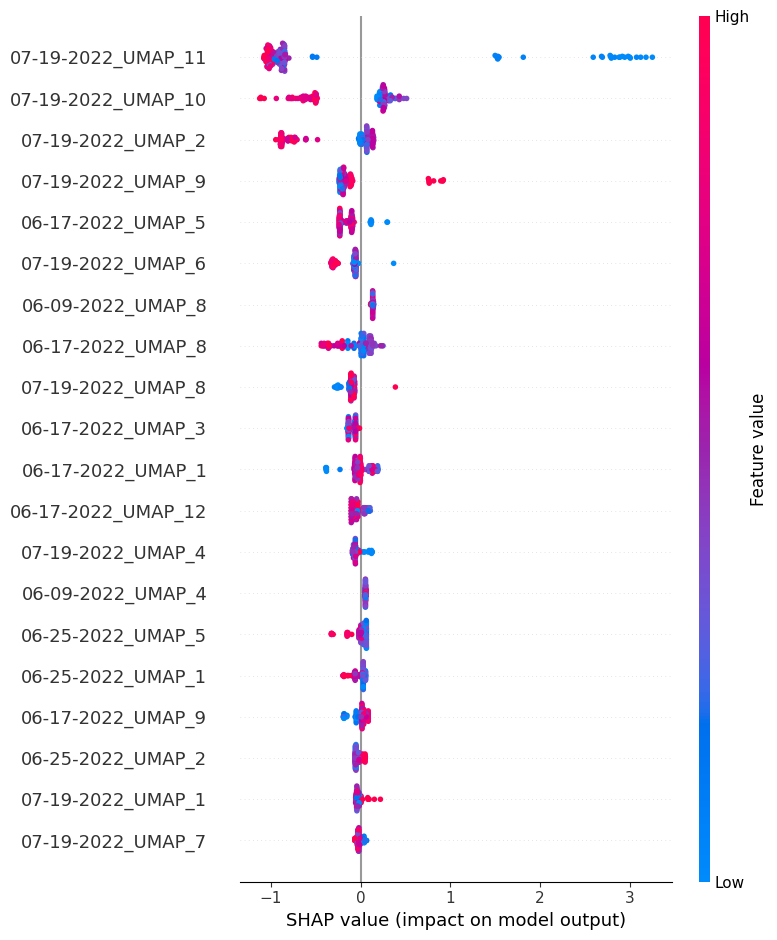

In [40]:
shap.summary_plot(shapValues, plot_type="dot", feature_names=dfWideTest.columns[6:])

In [14]:
def regressionActivationMap(img, model, lastConvLayerName, targetValue):
    gradModel = tf.keras.models.Model(
        [model.inputs], [model.get_layer(lastConvLayerName).output, model.output]
    )

    # compute the predicted value using the model
    with tf.GradientTape() as tape:
        lastConvOutput, pred = gradModel(img)

        # modify the loss function for regression (MSE loss)
        loss = tf.keras.losses.mean_squared_error(targetValue, pred)

    # compute gradients of the loss with respect to the activations of the last conv layer
    grads = tape.gradient(loss, lastConvOutput)

    # compute the weight of each feature map (global average pooling)
    grads = tf.abs(grads)
    pooledGrads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # compute a single heatmap by multiplying each feature map by its weight
    heatmap = lastConvOutput[0] @ pooledGrads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap


def resizeHeatmap(heatmap, shape):
    heatmap = scipy.ndimage.zoom(
        heatmap,
        (
            shape[0] / heatmap.shape[0],
            shape[1] / heatmap.shape[1],
            shape[2] / heatmap.shape[2],
        ),
    )

    return heatmap

In [16]:
lastConvLayerName = "conv3d_3"
plotIndex = 116
heatmap = resizeHeatmap(
    regressionActivationMap(
        np.expand_dims(xTestScaled[plotIndex], axis=0),
        h2a4m1,
        lastConvLayerName,
        yTest[plotIndex],
    ),
    xTestScaled[0].shape,
)

del lastConvLayerName

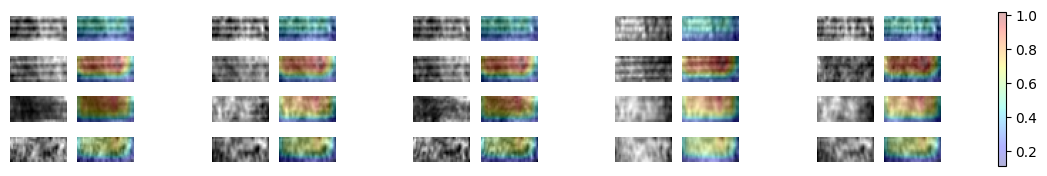

In [17]:
rows = xTestScaled.shape[1]
cols = 2 * 5 + 4

row = 0
fig, ax = plt.subplots(rows, cols, figsize=(15, 2))
for timepoint in range(xTestScaled.shape[1]):
    col = 0
    for channel in range(xTestScaled.shape[-1]):
        ax[row, col].axis("off")

        if col in [2, 5, 8, 11]:
            col += 1

        ax[row, col].axis("off")
        ax[row, col + 1].axis("off")

        img0 = ax[row, col].imshow(
            xTestScaled[plotIndex, timepoint, :, :, channel], cmap="gray"
        )
        ax[row, col + 1].imshow(
            xTestScaled[plotIndex, timepoint, :, :, channel], cmap="gray"
        )
        img1 = ax[row, col + 1].imshow(
            heatmap[timepoint, :, :],
            cmap="jet",
            alpha=0.3,
            extent=img0.get_extent(),
            vmin=heatmap.min(),
            vmax=heatmap.max(),
        )

        col += 2

    row += 1

fig.colorbar(img1, ax=ax.ravel().tolist())

del img0, img1, rows, cols
plt.show()

#### Export Results


In [56]:
results.to_csv("../Outputs/predictions.csv", index=False)